In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from shapely.geometry import box, LineString
import datetime

In [18]:
%matplotlib widget
plt.style.use("dark_background")

In [2]:
df1, df2 = pd.read_csv('data/kaggle/test.csv'), pd.read_csv('data/kaggle/train.csv')
df2 = df2[df1.columns]
df = pd.concat([df1, df2]).reset_index()
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# las coordenadas tienen 6 grados de presicion, pero con 4 tengo 10 metros de presición. redondeo a 4 y agrego.
coords_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude', 'dropoff_latitude'] 
df[coords_cols] = df[coords_cols].round(4)
df.head()

,index,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,0,id3004672,1,2016-06-30 23:59:58,1,-73.9881,40.7320,-73.9902,40.7567,N
1,1,id3505355,1,2016-06-30 23:59:53,1,-73.9642,40.6800,-73.9598,40.6554,N
2,2,id1217141,1,2016-06-30 23:59:47,1,-73.9974,40.7376,-73.9862,40.7295,N
3,3,id2150126,2,2016-06-30 23:59:41,1,-73.9561,40.7719,-73.9864,40.7305,N
4,4,id1598245,1,2016-06-30 23:59:33,1,-73.9702,40.7615,-73.9615,40.7559,N


In [3]:
start_date, end_date = df.pickup_datetime.min(), df.pickup_datetime.min() + datetime.timedelta(days=7)
week_data = df[(df.pickup_datetime>= start_date) & (df.pickup_datetime<end_date)]
week_data.shape

(70010, 10)

In [4]:
lines = [LineString([(r['pickup_longitude'], r['pickup_latitude']), (r['dropoff_longitude'], r['dropoff_latitude'])]) for _, r in week_data.iterrows()]
lines = gpd.GeoDataFrame(geometry=lines, crs='EPSG:4326')
lines['length'] = lines.to_crs('EPSG:32618').geometry.length
lmin, lmax = np.percentile(lines['length'], [5, 95])
lines = lines[(lines['length']>=lmin) & (lines['length']<=lmax)]

In [5]:
lines.to_file('data/rides/rides.shp')

In [72]:
fig, ax = plt.subplots(figsize=(10,10));
xmin, xmax, ymin, ymax = -74.1, -73.7, 40.6, 40.9
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off');
lines.plot(alpha=0.05, figsize=(10,10), ax=ax, color='#f2f0b3')
zones.dissolve().boundary.plot(ax=ax, color='white', linewidth=.15)

<ipython-input-72-5bba8a2ed71e>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10));


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [104]:
sample = df.sample(frac=1).copy()
departures = (
    sample.groupby(['pickup_longitude', 'pickup_latitude'])['id'].count()
    .reset_index()
    .rename(columns={
        'id': 'n',
        'pickup_latitude': 'lat',
        'pickup_longitude': 'lng'
    })
)
#departures = gpd.GeoDataFrame(departures, geometry=gpd.points_from_xy(departures.lng, departures.lat), crs="EPSG:4326")
arrivals = (
    sample.groupby(['dropoff_longitude', 'dropoff_latitude'])['id'].count()   
    .reset_index()
    .rename(columns={
        'id': 'n',
        'dropoff_latitude': 'lat',
        'dropoff_longitude': 'lng'
    }))
#arrivals = gpd.GeoDataFrame(arrivals, geometry=gpd.points_from_xy(arrivals.lng, arrivals.lat), crs="EPSG:4326")

In [51]:
zones = gpd.read_file('data/zones/zones.shp')
road = gpd.read_file('data/road/road.shp')

In [79]:
((minx, maxx), (miny,maxy)) = np.percentile(df.pickup_longitude,[.01, 99.99]), np.percentile(df.pickup_latitude,[.01, 99.9])

bbox = box(minx,miny, maxx, maxy)
bbox = gpd.GeoDataFrame(geometry=[bbox], crs='EPSG:4326')
# road_color = '#191919'
# road.plot(color=road_color)
gdf = road.sample(1000)#.intersection(bbox).reset_index().drop('index',1).rename(columns={0:'geom'}).set_geometry('geom')
# gdf = gdf[gdf]

In [85]:
road_bbox = gpd.sjoin(road, bbox)

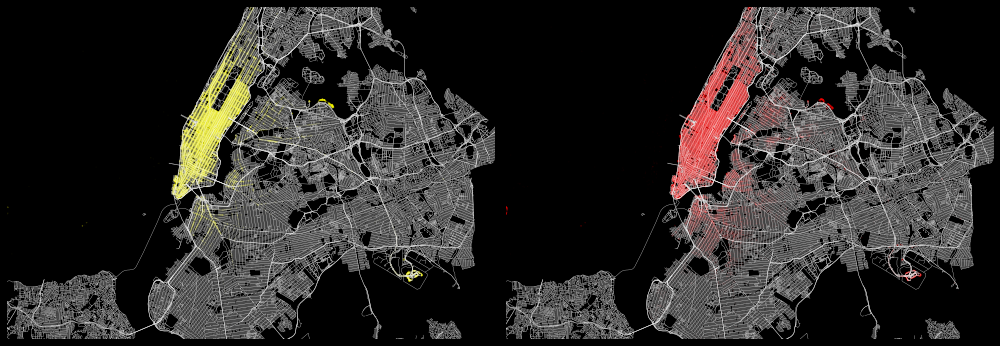

In [106]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))
road_bbox.plot(ax=ax1, color='whitesmoke', linewidth=0.3)
road_bbox.plot(ax=ax2, color='whitesmoke', linewidth=0.3)
departures.plot('lng', 'lat', kind='scatter', marker='.', ax=ax1, s=np.log10(departures['n'])/30, alpha=0.3, c='yellow')
arrivals.plot('lng', 'lat', kind='scatter', marker='.', ax=ax2, s=np.log10(arrivals['n'])/30, alpha=0.3, c='red')
for ax in [ax1, ax2]:
    ax.set_xlim(minx, maxx);
    ax.set_ylim(miny, maxy);
    ax.axis('off')
    #ax.set_facecolor('black')
    #ax.set_aspect('equal')
plt.tight_layout()

In [108]:
fig.savefig('taxirides.png', dpi=500, facecolor=fig.get_facecolor(), edgecolor='none');

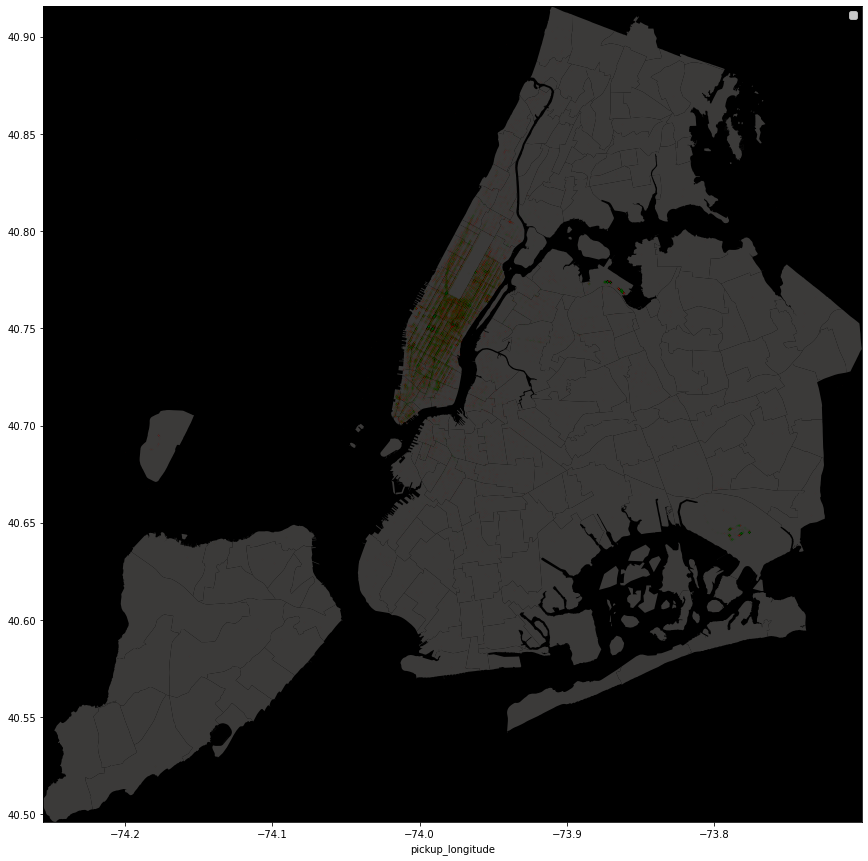

In [53]:
manhattan = zones[zones.borough.eq('Manhattan')]


fig, ax = plt.subplots(figsize=(15,15))
sample = df.sample(25000)
#manhattan.plot(ax=ax, color='black')
zones.plot(ax=ax, color='#3b3a39')
minx, miny, maxx, maxy = zones.geometry.total_bounds

sample.plot('dropoff_longitude', 'dropoff_latitude', style='o', ax=ax, color='red', ms=0.2, alpha=0.05)
sample.plot('pickup_longitude', 'pickup_latitude', style='o', ax=ax, color='green', ms=0.2, alpha=0.05)

ax.set_facecolor('black')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.legend('');